# Assignment 2: Working with Word Embeddings

In this assigment will learn how to work with word embeddings, and that with simple techniques we can implement cool things.

The assignment is divided in many parts that in most of the cases do not need code implementation. Hopefully, you would complete the assignment in short time and have great fun too. 

- __Part 0__: It is for setting up every thing, like load embeddings, normalize them etc.
- __Part 1__: We will use word embeddings for finding similar and relatead words.
- __Part 2__: We will learn scoring semantically words.
- __Part 3__: We will learn doing analogies, like `man-king` and `woman-queen`
- __Part 4__: We will learn visualizing embeddings.

## Part 0: Set up

We first define some helper functions for printing results and reading embeddings.

In [1]:
def print_header(title):
    print('┌───────────────────────────────────────────────────────────────┐')
    print('│{0:^63}│'.format(title))
    print('├──────────┬─────────────────────────────┬──────────┬───────────┤')

def print_footer():
    print('└──────────┴─────────────────────────────┴──────────┴───────────┘')

def print_oov(oov):
    if len(oov) > 0:
        print('OOV: {0}'.format(', '.join(oov)))

def print_row(index, last, trg_words, knn, sim):
    if last >= index or index < 0:
        return last
    if last < index - 1:
        print('│  {0:>5}  │  {0:^25}  │  {0:>5}   │  {0:^7} │'.format('⋮'))
    word = trg_words[knn[index]]
    word = ('{0:^25}').format(word)
    print('│  {0:>6}  │  {1}  │  {2:>6}  │  {3:7.4f}  │'.format(index + 1, word, knn[index], sim[knn[index]]))
    return index

In [2]:
import numpy as np

def read(file, threshold=0, dim=50, vocabulary=None):
    count = 400000 if threshold <= 0 else min(threshold, 400000)
    words = []
    matrix = np.empty((count, dim)) if vocabulary is None else []
    for i in range(count):
        word, vec = file.readline().decode('utf-8').split(' ', 1)
        if vocabulary is None:
            words.append(word)
            matrix[i] = np.fromstring(vec, sep=' ')
        elif word in vocabulary:
            words.append(word)
            matrix.append(np.fromstring(vec, sep=' '))
    return (words, matrix) if vocabulary is None else (words, np.array(matrix))

In [3]:
def length_normalize(matrix):
    norms = np.sqrt(np.sum(matrix**2, axis=1))
    norms[norms == 0] = 1
    return matrix / norms[:, np.newaxis]

__Load data__

First let's load a set of 50D word vectors from GloVe. If you want to run local you can download them at the following [url](http://nlp.stanford.edu/data/glove.6B.zip) (1GB). The zip file includes embeddings of different dimensionality (50d, 100d, 200d, 300d) for a vocabulary of 400000 words. Decompress them and place somewhere, for example in `./embeddings/` folder

`glove_home` below specifies the location of the unzipped file. 

Variables like `matrix` and `word2ind` are used below in the notebook by different functions, so you need first load data in order to make everything work.

In [4]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/LAP/Subjects/DL/labs

/content/drive/MyDrive/LAP/Subjects/DL/labs


In [6]:
import bz2

# Read input embeddings
glove_home = '../data/embeddings/glove.6B.50d.txt.bz2'
embsfile = bz2.open(glove_home)
words, matrix = read(embsfile)

# Length normalize embeddings so their dot product effectively computes the cosine similarity
matrix = length_normalize(matrix)

# Build word to index map
word2ind = {word: i for i, word in enumerate(words)}

## Part 1: Semantically similar/related words

In [7]:
def knn(word, k=10):
    try:
        i = word2ind[word]
        sim = matrix[i].dot(matrix.T)
        knn = np.argsort(-sim)
    except KeyError:
        print_header('{0} (OOV)'.format(word))
        print_footer()
        print()
        return
    print_header('{0} ({1})'.format(word, i + 1))
    last = -1
    for j in range(k):
        word = words[knn[j]]
        last = print_row(j, last=last, trg_words=words, knn=knn, sim=sim)
    last = print_row(len(knn)-1, last=last, trg_words=words, knn=knn, sim=sim)
    print_footer()
    print()


`knn` function retrieve the _k_ most similar/related words of the target word according to the given embedding space. The output looks like the following:

   - fist column for nearest neighbour index
   - second column for nearest neighbour word
   - third column for index of word in frequency ranking (1 is most frequent)
   - last column for cosine (1 for perfect similarity)



In [8]:
# Show the 30 nearest neighbors
knn('pound', k=30)

┌───────────────────────────────────────────────────────────────┐
│                         pound (3606)                          │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │            pound            │    3605  │   1.0000  │
│       2  │           pounds            │    1696  │   0.8113  │
│       3  │           dollar            │     678  │   0.7066  │
│       4  │           ounces            │   10573  │   0.7060  │
│       5  │            cent             │    4368  │   0.7049  │
│       6  │          kilogram           │   19141  │   0.6869  │
│       7  │            ounce            │    6215  │   0.6850  │
│       8  │             ton             │    8811  │   0.6791  │
│       9  │           barrel            │    3401  │   0.6744  │
│      10  │            kilo             │   27447  │   0.6675  │
│      11  │            pork             │    7635  │   0.6660  │
│      12  │             cut             │     611  │   0.6609  │
│      13 

### TODO1: 
Check the results for the words below. List which words you think are working well, and which ones it is failing. You can use the example in the slide (page 27) as reference.

- france, jesus, xbox, reddish, scratched, megabits 

Try any other word you fancy, and write any comment you might have. Keep a copy of the output including 30 nearest neighbours.

In [9]:
knn('france',k=30)

┌───────────────────────────────────────────────────────────────┐
│                         france (388)                          │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           france            │     387  │   1.0000  │
│       2  │           french            │     348  │   0.8868  │
│       3  │           belgium           │    2975  │   0.8632  │
│       4  │            paris            │    1035  │   0.8025  │
│       5  │            spain            │    1029  │   0.7909  │
│       6  │         netherlands         │    2238  │   0.7894  │
│       7  │            italy            │     931  │   0.7789  │
│       8  │           germany           │     509  │   0.7745  │
│       9  │          european           │     291  │   0.7627  │
│      10  │         switzerland         │    2311  │   0.7578  │
│      11  │           europe            │     525  │   0.7540  │
│      12  │           belgian           │    4072  │   0.7460  │
│      13 

In [10]:
knn('jesus',k=30)

┌───────────────────────────────────────────────────────────────┐
│                         jesus (3994)                          │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │            jesus            │    3993  │   1.0000  │
│       2  │           christ            │    4904  │   0.8533  │
│       3  │             god             │    1533  │   0.7633  │
│       4  │        resurrection         │   16493  │   0.7583  │
│       5  │         crucifixion         │   27882  │   0.7296  │
│       6  │           divine            │    8661  │   0.7133  │
│       7  │           blessed           │   10141  │   0.6988  │
│       8  │           priest            │    4314  │   0.6939  │
│       9  │            holy             │    2677  │   0.6904  │
│      10  │            faith            │    2714  │   0.6879  │
│      11  │          disciples          │   18225  │   0.6819  │
│      12  │           sacred            │    6404  │   0.6781  │
│      13 

In [11]:
knn('xbox',k=30)

┌───────────────────────────────────────────────────────────────┐
│                         xbox (12812)                          │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │            xbox             │   12811  │   1.0000  │
│       2  │         playstation         │   10498  │   0.9490  │
│       3  │             ps2             │   49520  │   0.8948  │
│       4  │             ps3             │   40478  │   0.8918  │
│       5  │          nintendo           │    9778  │   0.8916  │
│       6  │           console           │   11125  │   0.8815  │
│       7  │          gamecube           │   39638  │   0.8753  │
│       8  │          consoles           │   19550  │   0.8698  │
│       9  │          dreamcast          │   39767  │   0.8659  │
│      10  │             wii             │   16452  │   0.8364  │
│      11  │             psp             │   35248  │   0.8011  │
│      12  │             ds              │   19150  │   0.7966  │
│      13 

In [12]:
knn('reddish',k=30)

┌───────────────────────────────────────────────────────────────┐
│                        reddish (24228)                        │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           reddish           │   24227  │   1.0000  │
│       2  │          yellowish          │   31415  │   0.9405  │
│       3  │           pinkish           │   55952  │   0.9055  │
│       4  │          greenish           │   39602  │   0.8990  │
│       5  │           grayish           │   60286  │   0.8976  │
│       6  │           mottled           │   48874  │   0.8832  │
│       7  │          purplish           │   60041  │   0.8797  │
│       8  │          brownish           │   34620  │   0.8794  │
│       9  │           bluish            │   50275  │   0.8793  │
│      10  │           whitish           │   37132  │   0.8692  │
│      11  │        reddish-brown        │   68131  │   0.8682  │
│      12  │          red-brown          │   98485  │   0.8191  │
│      13 

In [13]:
knn('scratched',k=30)

┌───────────────────────────────────────────────────────────────┐
│                       scratched (21526)                       │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │          scratched          │   21525  │   1.0000  │
│       2  │          blistered          │   61508  │   0.7427  │
│       3  │        inexplicably         │   28658  │   0.7210  │
│       4  │           punched           │   14019  │   0.7095  │
│       5  │           popped            │   15366  │   0.7019  │
│       6  │            sore             │   10255  │   0.7017  │
│       7  │           bruised           │   14726  │   0.7013  │
│       8  │           bashed            │   46651  │   0.6841  │
│       9  │           bruise            │   33626  │   0.6792  │
│      10  │          bothered           │   12503  │   0.6767  │
│      11  │           nicked            │   55977  │   0.6756  │
│      12  │            legs             │    4376  │   0.6756  │
│      13 

In [14]:
knn('megabits',k=30)

┌───────────────────────────────────────────────────────────────┐
│                       megabits (70921)                        │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │          megabits           │   70920  │   1.0000  │
│       2  │            mbps             │  101347  │   0.8837  │
│       3  │          kilobits           │   85105  │   0.8322  │
│       4  │           mbit/s            │   46870  │   0.8159  │
│       5  │          gigabits           │  149316  │   0.8008  │
│       6  │           gbit/s            │   77801  │   0.7204  │
│       7  │            gbps             │  255514  │   0.7173  │
│       8  │            mb/s             │  142609  │   0.7049  │
│       9  │           kbit/s            │   60227  │   0.6979  │
│      10  │            kbps             │   89345  │   0.6969  │
│      11  │           speeds            │    8714  │   0.6710  │
│      12  │        milliseconds         │   57155  │   0.6689  │
│      13 

## Part 2: Semantic orientation

The __semantic orientation__ method of [Turney and Littman 2003](http://doi.acm.org/10.1145/944012.944013) is a method for automatically scoring words along some single semantic dimension like sentiment. It works from a pair of small seed sets of words that represent two opposing points on that dimension.

In [15]:
seed_pos = ['good', 'great', 'awesome', 'like', 'love']
seed_neg = ['bad', 'awful', 'terrible', 'hate', 'dislike']

def determine_coefficient(candidate_word, seed_pos, seed_neg):
    pos_ind = np.array([word2ind[word] for word in seed_pos])
    pos_mat = matrix[pos_ind]

    neg_ind = np.array([word2ind[word] for word in seed_neg])
    neg_mat = matrix[neg_ind]

    i = word2ind[candidate_word]

    pos_sim = np.sum(matrix[i].dot(pos_mat.T))
    neg_sim = np.sum(matrix[i].dot(neg_mat.T))

    return pos_sim - neg_sim

print(determine_coefficient('abhorrent', seed_pos, seed_neg))
print(determine_coefficient('vacations', seed_pos, seed_neg))
print(determine_coefficient('hunger', seed_pos, seed_neg))

-1.3560851191875911
0.3317376345453793
-0.38044815398081977


And sort our vocabulary by its score along the axis. For now, we're only scoring frequent words, since this process can be slow.

In [16]:
from operator import itemgetter

scored_words = [(word, determine_coefficient(word, seed_pos, seed_neg)) for word in words[1:5000]]
sorted_words = sorted(scored_words, key=itemgetter(1), reverse=True)

In [17]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

pp.pprint(sorted_words[:10])
pp.pprint(sorted_words[-10:])

[   ('golden', 1.663179307232638),
    ('alongside', 1.6100037063048223),
    ('award', 1.5785573346280575),
    ('named', 1.5611442789068484),
    ('star', 1.530620407370102),
    ('master', 1.5204344791642384),
    ('best', 1.4783995653223534),
    ('field', 1.4646711368545025),
    ('features', 1.4618836930255577),
    ('holds', 1.4500300641531108)]
[   ('abuse', -0.8344062181348662),
    ('consequences', -0.8502258707660664),
    ('complaints', -0.8506094485601927),
    ('arrests', -0.8559244910581884),
    ('discrimination', -0.8616654123051029),
    ('unrest', -0.8655146415017352),
    ('violations', -0.9471621463990337),
    ('accusations', -0.9740514087327838),
    ('incidents', -0.9876909151109379),
    ('killings', -0.9966174868152311)]


### TODO 2
Spend a few minutes exploring possible seed sets for semantic dimensions other than sentiment (e.g. "animals" vs "tools"). 

- Define your semantic orientation with the two sets of seeds.
- Report (write it here in the notebook) what works, what doesn't, and why?

In [18]:
seed_animal = ['dog', 'cat', 'lion', 'tiger', 'bird']
seed_tool = ['computer', 'knife', 'fork', 'pen', 'pencil']

In [19]:
from operator import itemgetter

scored_words = [(word, determine_coefficient(word, seed_animal, seed_tool)) for word in words[1:5000]]
sorted_words = sorted(scored_words, key=itemgetter(1), reverse=True)

In [20]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

pp.pprint(sorted_words[:10])
pp.pprint(sorted_words[-10:])

[   ('bird', 2.5327336568076655),
    ('tiger', 2.2145428539490015),
    ('birds', 2.094787591146252),
    ('wildlife', 2.092690413424215),
    ('animals', 2.019139978521478),
    ('species', 1.9459288151773781),
    ('cricket', 1.9200933483090101),
    ('wild', 1.8913888460689354),
    ('dog', 1.812199502355912),
    ('africa', 1.7680603600106204)]
[   ('file', -1.1138613250479321),
    ('arguments', -1.1402672114038248),
    ('automatic', -1.1418972457663628),
    ('optional', -1.184859556315706),
    ('files', -1.1889677163489667),
    ('fax', -1.2566833644156588),
    ('papers', -1.2756903745447943),
    ('milosevic', -1.279274255026717),
    ('wire', -1.4115988081664657),
    ('electrical', -1.4525642548951665)]


## Part 3: Analogy

Next, let's try to build a similar function for determining which words are likely to be good completions for an analogy. Our inputs will be a pair and a singleton word that together represent an analogy problem.

- Analogy pair:  good $\rightarrow$ best,  man $\rightarrow$ king
- Analogy problem: bad $\rightarrow$ ??,  woman $\rightarrow$ ??


Remenber from slides:

- Task: _a is to b as c is to?_
    + $a-b \approx c-d$
    + $c-a+b \approx d$
    + $argmax_{d\in V} (cos(d , c−a+b))$

In [21]:
def analogy(pront_pair, pront_seed, k=10):
    # The function make use of embedding matrix and word indices.
    # Recall to load data and inialize matrix and word2ind variables.
    try:
        i = word2ind[pront_pair[0]]
        w1v = matrix[i]
    except KeyError:
        print_header('{0} (OOV)'.format(pront_pair[0]))
        print_footer()
        print()
        return
    try:
        i = word2ind[pront_pair[1]]
        w2v = matrix[i]
    except KeyError:
        print_header('{0} (OOV)'.format(pront_pair[1]))
        print_footer()
        print()
        return
    try:
        i = word2ind[pront_seed]
        w3v = matrix[i]
    except KeyError:
        print_header('{0} (OOV)'.format(pront_seed))
        print_footer()
        print()
        return
    
    # obtain k nearest words according to the analogy
    mat = w3v - w1v + w2v
    sim = mat.dot(matrix.T)
    knn = np.argsort(-sim)

    print_header('{0} - {1} + {2}'.format(pront_pair[0], pront_pair[1], pront_seed))
    last = -1
    for j in range(k): 
        word = words[knn[j]]
        last = print_row(j, last=last, trg_words=words, knn=knn, sim=sim)
    last = print_row(len(knn)-1, last=last, trg_words=words, knn=knn, sim=sim)
    print_footer()
    print()


In [22]:
prompt_pair = ('good', 'best')
prompt_seed = 'bad'
analogy(prompt_pair, prompt_seed)

prompt_pair = ('man', 'king')
prompt_seed = 'woman'
analogy(prompt_pair, prompt_seed)

┌───────────────────────────────────────────────────────────────┐
│                       good - best + bad                       │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │             bad             │     978  │   0.8501  │
│       2  │            best             │     254  │   0.7920  │
│       3  │            ever             │     661  │   0.7695  │
│       4  │            movie            │    1005  │   0.7614  │
│       5  │             big             │     365  │   0.7512  │
│       6  │            worst            │    1607  │   0.7484  │
│       7  │           movies            │    2459  │   0.7357  │
│       8  │           series            │     281  │   0.7346  │
│       9  │            play             │     282  │   0.7274  │
│      10  │            gone             │    1527  │   0.7250  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           noapara           │  389264  │  -0.7174  │
└──────────┴

### TODO3
-  The embeddings space can be used to do analogies. Please examine the formula in the of slides, and apply it to the three embeddings in the function below `analogy`. If you programmed it correctly, the following analogy should work:
    + `man:king; woman:?` (Note that, in the result list, words in the query need to be ignored)
    

- Check 10 of the analogie below and report in which position is the correct answer (discounting the words in the query, of course).

![](https://drive.google.com/uc?id=1Uoa-17hHm2mDKi1ZtIaVrjj60JTBS8rV)


In [23]:
analogy(['france', 'paris'], 'italy') # rome 1

┌───────────────────────────────────────────────────────────────┐
│                    france - paris + italy                     │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │            rome             │    2618  │   0.8547  │
│       2  │            italy            │     931  │   0.8122  │
│       3  │            paris            │    1035  │   0.7886  │
│       4  │            milan            │    2777  │   0.7841  │
│       5  │            turin            │    9084  │   0.7740  │
│       6  │           venice            │    8081  │   0.7665  │
│       7  │           madrid            │    2471  │   0.7639  │
│       8  │           italian           │    1031  │   0.7586  │
│       9  │            aires            │    7131  │   0.7501  │
│      10  │           naples            │    9611  │   0.7478  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           tarkas            │  323931  │  -0.7629  │
└──────────┴

In [24]:
analogy(['big', 'bigger'], 'small') # smaller 2

┌───────────────────────────────────────────────────────────────┐
│                     big - bigger + small                      │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           larger            │    1758  │   1.0408  │
│       2  │           smaller           │    1776  │   0.9970  │
│       3  │            large            │     426  │   0.9960  │
│       4  │            small            │     357  │   0.9910  │
│       5  │          normally           │    3520  │   0.8842  │
│       6  │          typically          │    2681  │   0.8801  │
│       7  │           usually           │    1140  │   0.8666  │
│       8  │            tiny             │    3293  │   0.8586  │
│       9  │            sized            │    6424  │   0.8516  │
│      10  │            size             │    1275  │   0.8487  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │            kd94             │  174703  │  -0.7939  │
└──────────┴

In [25]:
analogy(['miami', 'florida'], 'baltimore') # maryland -

┌───────────────────────────────────────────────────────────────┐
│                  miami - florida + baltimore                  │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │          baltimore          │    3680  │   0.9366  │
│       2  │           kansas            │    2260  │   0.9087  │
│       3  │           arizona           │    2203  │   0.8768  │
│       4  │        philadelphia         │    2201  │   0.8763  │
│       5  │          minnesota          │    2794  │   0.8677  │
│       6  │           boston            │    1123  │   0.8610  │
│       7  │          carolina           │    1822  │   0.8492  │
│       8  │          virginia           │    1667  │   0.8415  │
│       9  │           florida           │     950  │   0.8394  │
│      10  │            texas            │     745  │   0.8380  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │          kerubino           │  220677  │  -0.7722  │
└──────────┴

In [26]:
analogy(['einstein', 'scientist'], 'messi') # midfielder 1

┌───────────────────────────────────────────────────────────────┐
│                 einstein - scientist + messi                  │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │         midfielder          │    3811  │   1.0094  │
│       2  │           striker           │    3246  │   1.0069  │
│       3  │          defender           │    3571  │   0.9644  │
│       4  │         argentinian         │   21801  │   0.9566  │
│       5  │          playmaker          │   18422  │   0.9517  │
│       6  │           winger            │    8613  │   0.9472  │
│       7  │           forlan            │   35074  │   0.9445  │
│       8  │           veteran           │    2584  │   0.9250  │
│       9  │            messi            │   19087  │   0.9110  │
│      10  │         goalkeeper          │    4482  │   0.9039  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │         weissenburg         │  251945  │  -0.9151  │
└──────────┴

In [27]:
analogy(['sarkozy', 'france'], 'berlusconi') # italy 2

┌───────────────────────────────────────────────────────────────┐
│                 sarkozy - france + berlusconi                 │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           france            │     387  │   0.8487  │
│       2  │            italy            │     931  │   0.8315  │
│       3  │           belgium           │    2975  │   0.8149  │
│       4  │            spain            │    1029  │   0.7892  │
│       5  │           french            │     348  │   0.7688  │
│       6  │           belgian           │    4072  │   0.7535  │
│       7  │           italian           │    1031  │   0.7448  │
│       8  │         netherlands         │    2238  │   0.7412  │
│       9  │            milan            │    2777  │   0.7361  │
│      10  │         switzerland         │    2311  │   0.7343  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │            kuss             │  332396  │  -0.7773  │
└──────────┴

In [28]:
analogy(['copper', 'cu'], 'zinc') # zn 2

┌───────────────────────────────────────────────────────────────┐
│                      copper - cu + zinc                       │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │             cu              │   24893  │   0.9522  │
│       2  │             zn              │  110078  │   0.8262  │
│       3  │            seeme            │  199418  │   0.8227  │
│       4  │             ei              │   50322  │   0.7974  │
│       5  │             iu              │   48051  │   0.7837  │
│       6  │             1,1             │  125263  │   0.7726  │
│       7  │             kj              │   51628  │   0.7564  │
│       8  │             bu              │   20530  │   0.7524  │
│       9  │             tes             │   84121  │   0.7357  │
│      10  │             gh              │   51119  │   0.7152  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │          skjeldal           │  254555  │  -0.5951  │
└──────────┴

In [29]:
analogy(['berlusconi', 'silvio'], 'sarkozy') # nicolas 5

┌───────────────────────────────────────────────────────────────┐
│                 berlusconi - silvio + sarkozy                 │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           sarkozy           │    4767  │   0.8941  │
│       2  │           chirac            │    3924  │   0.8283  │
│       3  │           jospin            │   15186  │   0.7964  │
│       4  │           silvio            │   10955  │   0.7925  │
│       5  │           nicolas           │    5660  │   0.7862  │
│       6  │            aznar            │   12299  │   0.7812  │
│       7  │          villepin           │   13736  │   0.7760  │
│       8  │          chretien           │   13546  │   0.7652  │
│       9  │          zapatero           │   12822  │   0.7648  │
│      10  │          balladur           │   24082  │   0.7627  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           birbhum           │  115013  │  -0.6277  │
└──────────┴

In [30]:
analogy(['microsoft', 'windows'], 'google') # android -

┌───────────────────────────────────────────────────────────────┐
│                 microsoft - windows + google                  │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           windows           │    2211  │   0.9040  │
│       2  │           window            │    3453  │   0.7955  │
│       3  │          clicking           │   21709  │   0.7588  │
│       4  │             web             │    1170  │   0.7559  │
│       5  │           screens           │    7715  │   0.7530  │
│       6  │          accessed           │   15202  │   0.7373  │
│       7  │           portals           │   27439  │   0.7350  │
│       8  │            onto             │    2178  │   0.7277  │
│       9  │            click            │    9641  │   0.7269  │
│      10  │          platforms          │    7419  │   0.7262  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           o'kane            │   93063  │  -0.6664  │
└──────────┴

In [31]:
analogy(['japan', 'sushi'], 'germany') # bratwurst -

┌───────────────────────────────────────────────────────────────┐
│                    japan - sushi + germany                    │
├──────────┬─────────────────────────────┬──────────┬───────────┤
│       1  │           gourmet           │   18038  │   0.8211  │
│       2  │            sushi            │   21961  │   0.7971  │
│       3  │            fries            │   18913  │   0.7921  │
│       4  │          sausages           │   30890  │   0.7727  │
│       5  │            deli             │   25404  │   0.7673  │
│       6  │         hamburgers          │   30970  │   0.7444  │
│       7  │           burgers           │   24045  │   0.7399  │
│       8  │          hamburger          │   16869  │   0.7395  │
│       9  │           bistro            │   33100  │   0.7310  │
│      10  │            chef             │    7309  │   0.7299  │
│      ⋮  │              ⋮              │      ⋮   │     ⋮    │
│  400000  │           jameer            │  101460  │  -0.6867  │
└──────────┴

## Part 4: Visualization
Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# reduce size of the matrix to speed up the operations
viz_words = 500
start_ind = 1000
end_ind = start_ind+viz_words
small_ind = np.array([word2ind[word] for word in words[start_ind:end_ind]])
small_word2ind = {word : i for i, word in enumerate(words[start_ind:end_ind])}
small_matrix =  matrix[small_ind]

# Project word embeddings to two-dimensions
tsne = TSNE()
embed_tsne = tsne.fit_transform(small_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


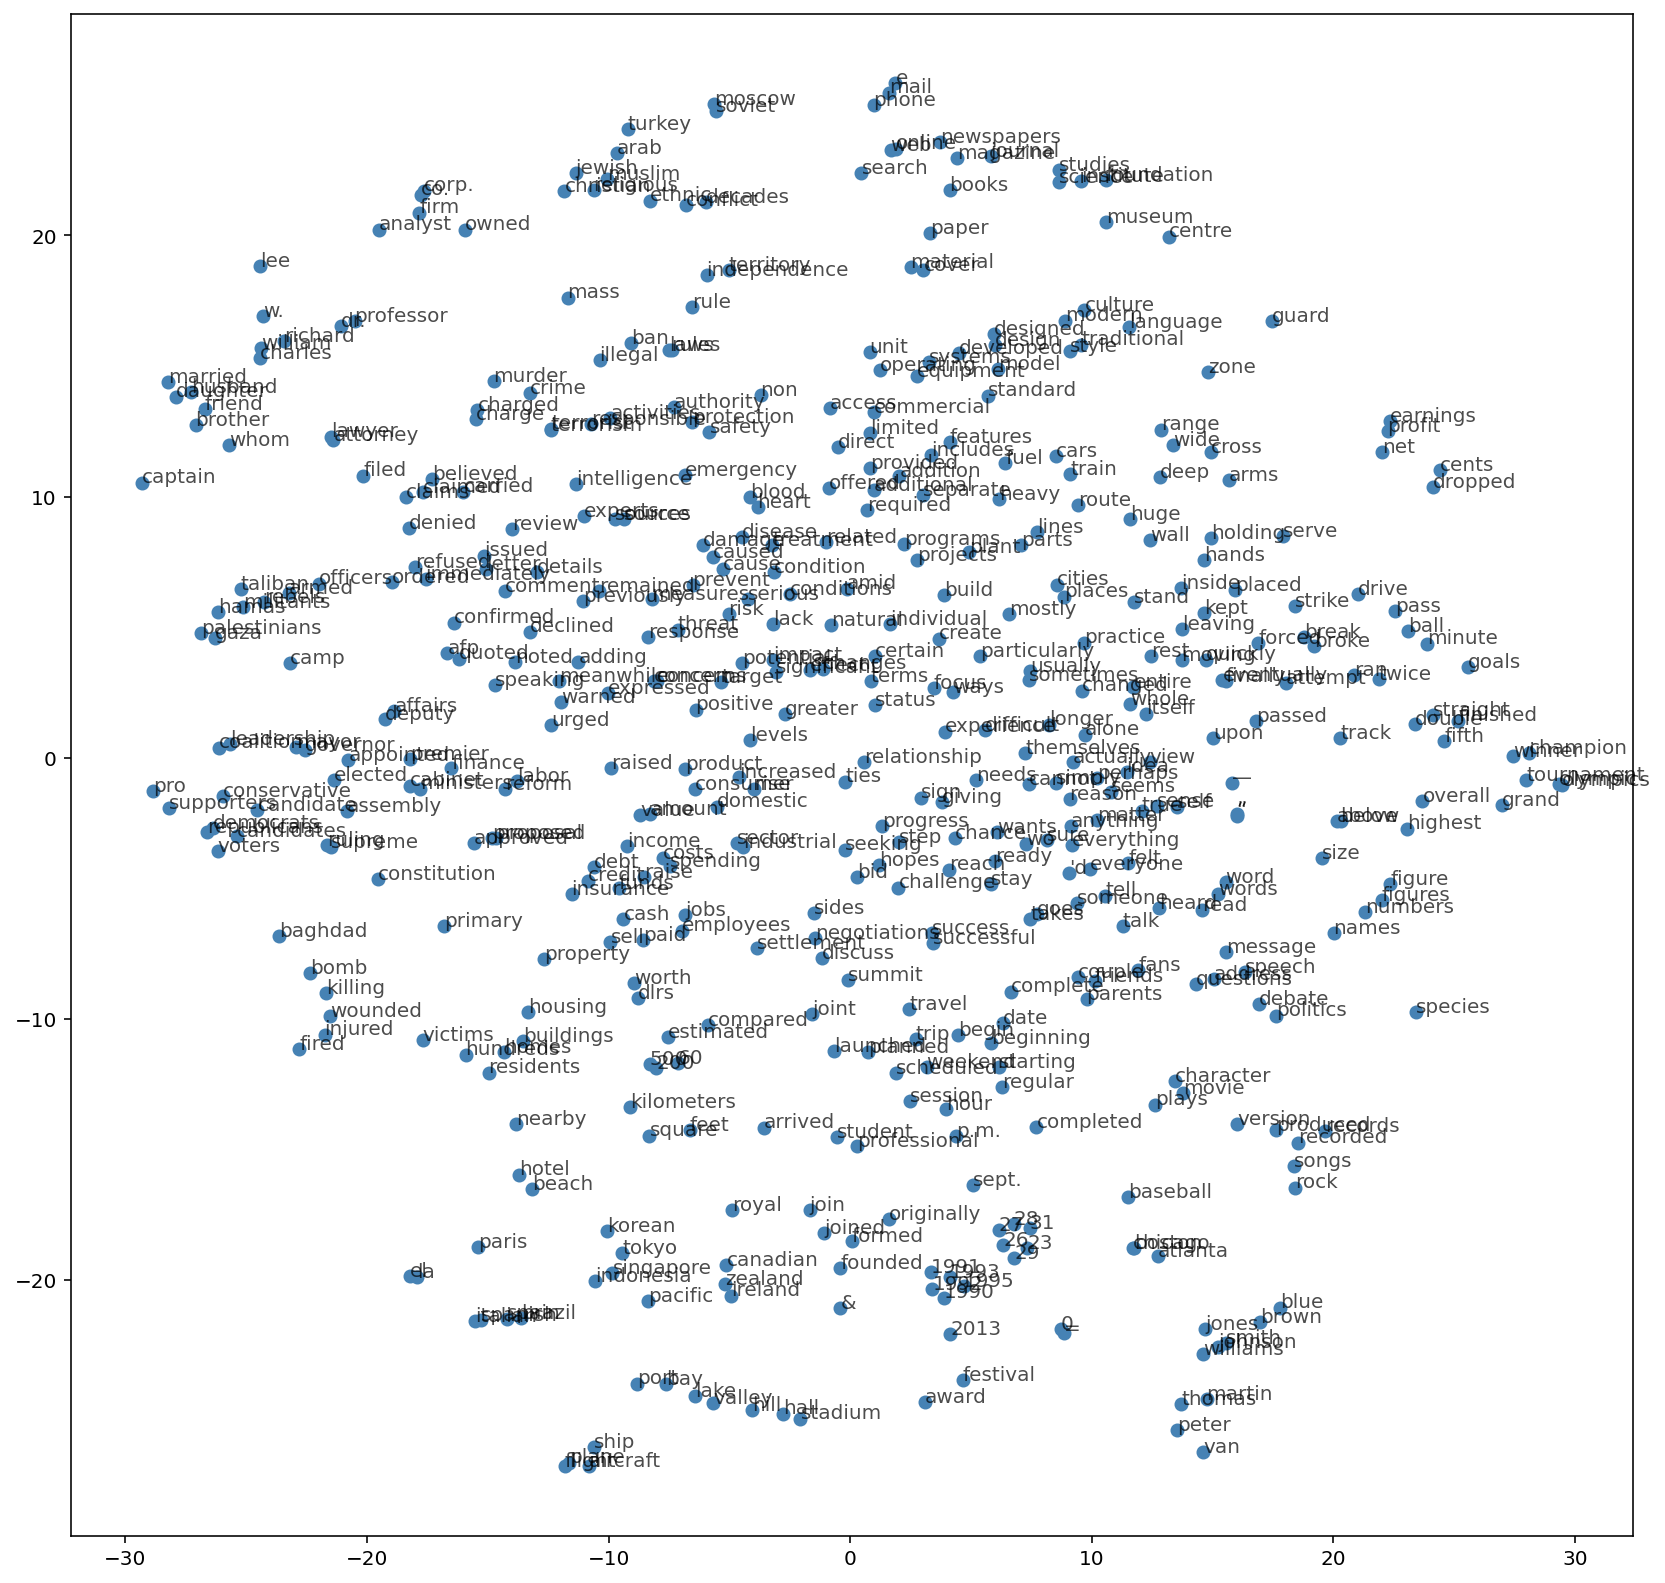

In [33]:
fig, ax = plt.subplots(figsize=(14, 14))
plt.scatter(x=embed_tsne[:,0], y=embed_tsne[:,1], c='steelblue')
for i, word in enumerate(words[start_ind:end_ind]):
    plt.annotate(word, (embed_tsne[small_word2ind[word], 0], embed_tsne[small_word2ind[word], 1]), alpha=0.7)

### TODO4
- Sort word according to some semantic dimension (you could use the one on sentiment)
- Plot some of them using T-SNE 
- It would help visualization coloring word-points according to their positive/negativ orientation 

In [34]:
seed_pos = ['good', 'great', 'awesome', 'like', 'love']
seed_neg = ['bad', 'awful', 'terrible', 'hate', 'dislike']

scored_words = [(word, determine_coefficient(word, seed_pos, seed_neg)) for word in words[1:5000]]
sorted_words = sorted(scored_words, key=itemgetter(1), reverse=True)

possitive_words = sorted_words[:50]
negative_words = sorted_words[-50:]
sentiment_words = possitive_words + negative_words
words = [word for (word, sent) in sentiment_words]
sents = [sent for (word, sent) in sentiment_words]

In [35]:
# reduce size of the matrix to speed up the operations
small_ind = np.array([word2ind[word] for word in words])
small_word2ind = {word : i for i, word in enumerate(words)}
small_matrix = matrix[small_ind]

In [36]:
# Project word embeddings to two-dimensions
tsne = TSNE()
embed_tsne = tsne.fit_transform(small_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


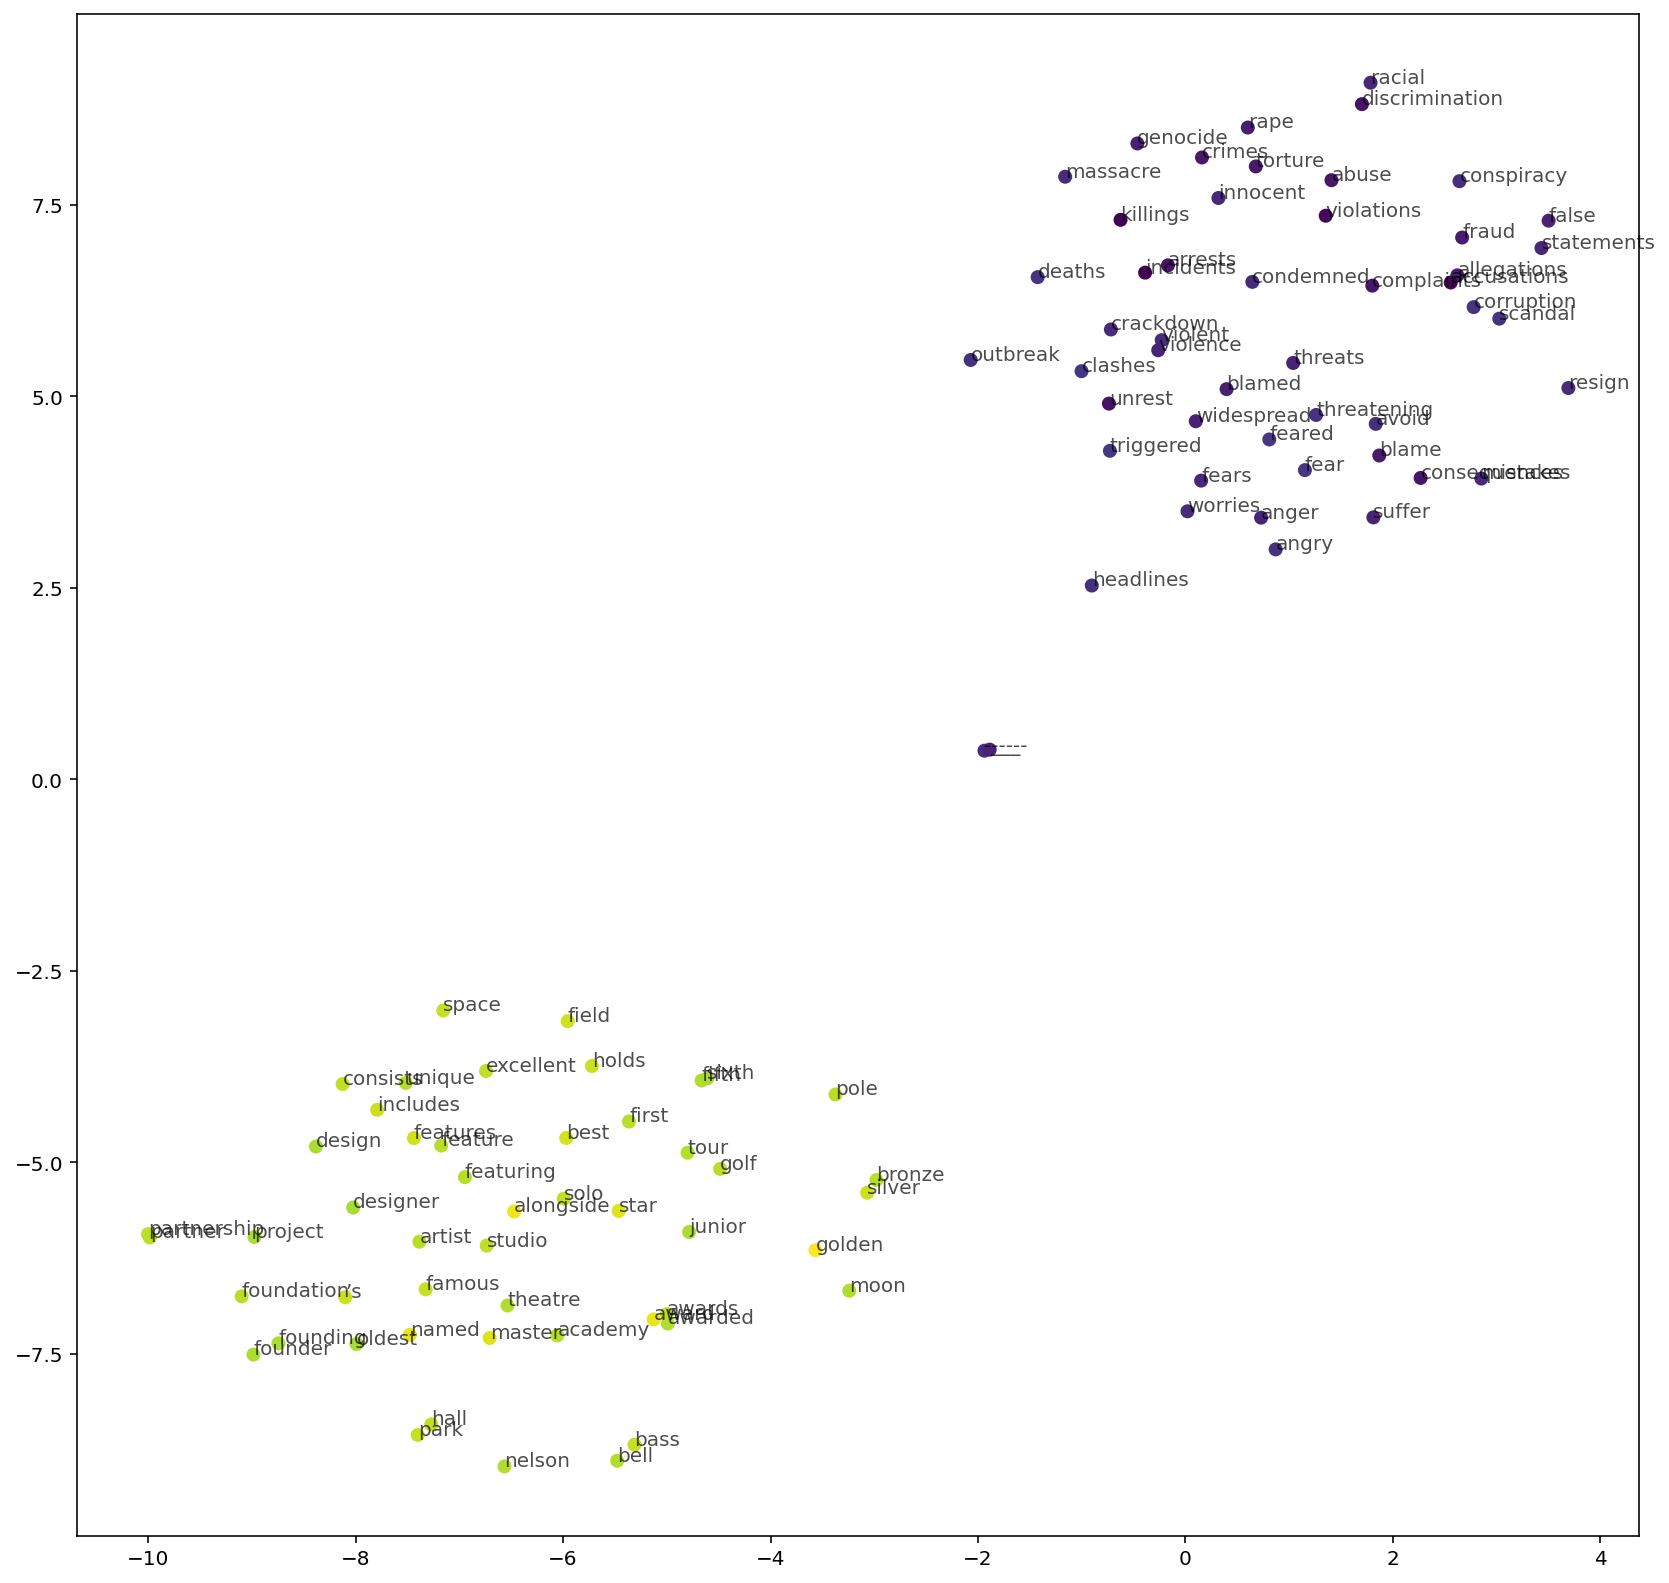

In [37]:
fig, ax = plt.subplots(figsize=(14, 14))
plt.scatter(x=embed_tsne[:,0], y=embed_tsne[:,1], c=sents)
for i, word in enumerate(words):
    plt.annotate(word, (embed_tsne[small_word2ind[word], 0], embed_tsne[small_word2ind[word], 1]), alpha=0.7)

# Atribution: 
Adapted by Oier Lopez de Lacalle, Olatz Perez de Viñaspre and Ander Barrena, based on the code by Mikel Artetxe at UPV/EHU